In [1]:
import pandas as pd
import numpy as np
import heartpy as hp
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns

### Data Extraction

In [2]:
data = pd.read_csv('data-clean.csv')
data_extraction = pd.DataFrame()

for i, ppg in enumerate(data['ppg']): 
  ppg = list(map(int, ppg.split(',')))

  try:
    data_extraction.at[i, 'actual_systole'] = data.at[i, 'actual_systole']
    data_extraction.at[i, 'actual_diastole'] = data.at[i, 'actual_diastole']
    data_extraction.at[i, 'age'] = data.at[i, 'age']
    data_extraction.at[i, 'weight'] = data.at[i, 'weight']
    wd, m = hp.process(np.array(ppg), sample_rate = 100.0)
    for key, value in m.items():
      data_extraction.at[i, key] = value
  except Exception as e:
    print(f"{i} - {e}")
    
data_extraction = data_extraction.dropna()
data_extraction.to_csv('data-extraction.csv', index = False)

c:\Python310\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Python310\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


### Normalization

In [3]:
data = pd.read_csv('data-extraction.csv')

bp = pd.DataFrame()
bp['actual_systole'] = data.pop('actual_systole')
bp['actual_diastole'] = data.pop('actual_diastole')

# Create a StandardScaler
standard_scaler = StandardScaler()

# Fit the scaler and transform the data
X_scaler = standard_scaler.fit(data)
joblib.dump(X_scaler, 'scaler.pkl')

standardized_data = pd.DataFrame(X_scaler.transform(data))
standardized_data.columns = data.columns

concatenated_df = pd.concat([bp, standardized_data], axis=1)

concatenated_df.to_csv('data-extraction-normalized.csv', index=False)

### Training Systole

kita punya 15 data X adalah [age, weight, bpm, ibi, sdnn, sdsd, rmssd, pnn20, pnn50, hr_mad, sd1, sd2, s, sd1/sd2, breathingrate]

coba training dengan semua kombinasi X

In [11]:
data = pd.read_csv('data-extraction-normalized.csv')


X_y = []

for i in data.columns:
  X_y.append(list(data[i]))
  
X = np.array(X_y[2:]).transpose()
y = np.array(X_y[0]) 

for i, X_combination in enumerate(generate_combinations(X)):
  # Split the dataset into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(np.array(list(X_combination)).transpose(), y, test_size=0.2, random_state=42)

  # Define the SVR model
  svr = SVR(kernel='rbf')

  # Define the parameter grid for hyperparameter tuning
  param_grid = {'C': [1,2,3,4,6,8,10,20,30,40,60,70,80,100,200,300,400], 'epsilon': [0.1,0.2,0.3,0.4,0.6,0.8,1,2,3,4,6,8,10,15,20]}
  # param_grid = {'C': np.arange(16, 400, 16), 'epsilon': np.arange(0.5, 15, 0.5)}


  # Create the GridSearchCV object
  grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_absolute_error')

  # Fit the model with the training data
  grid_search.fit(X_train, y_train)

  # best_model = grid_search.best_estimator_
  # joblib.dump(best_model, f"systole_model.pkl")

  # # Get the results as a Pandas DataFrame
  # results = pd.DataFrame(grid_search.cv_results_)

  # # Reshape the results for heatmap
  # heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')

  # Plot the heatmap
  # plt.figure(figsize=(16, 12))
  # sns.heatmap(heatmap_data, cmap='viridis', fmt=".4f", cbar_kws={'label': 'Mean Test Score'})
  # plt.title(f"Best param: {grid_search.best_params_}, with score: {grid_search.best_score_}, X: {','.join(features_combination[i])}")
  # plt.xlabel('C')
  # plt.ylabel('Epsilon')
  # plt.savefig(f"grid-search-result/systole/{i}_{','.join(features_combination[i])}.pkl")
  # plt.show()

  # # Print the best hyperparameters
  # print("Best hyperparameters:", grid_search.best_params_)
  # print("With Score:", grid_search.best_score_)

  joblib.dump(grid_search, f"grid-search-result/systole/{i}_{','.join(features_combination[i])}.pkl")

KeyboardInterrupt: 

# Training Diastole

C:\Users\ukisy\AppData\Local\Temp\ipykernel_14964\2671530248.py:34: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')


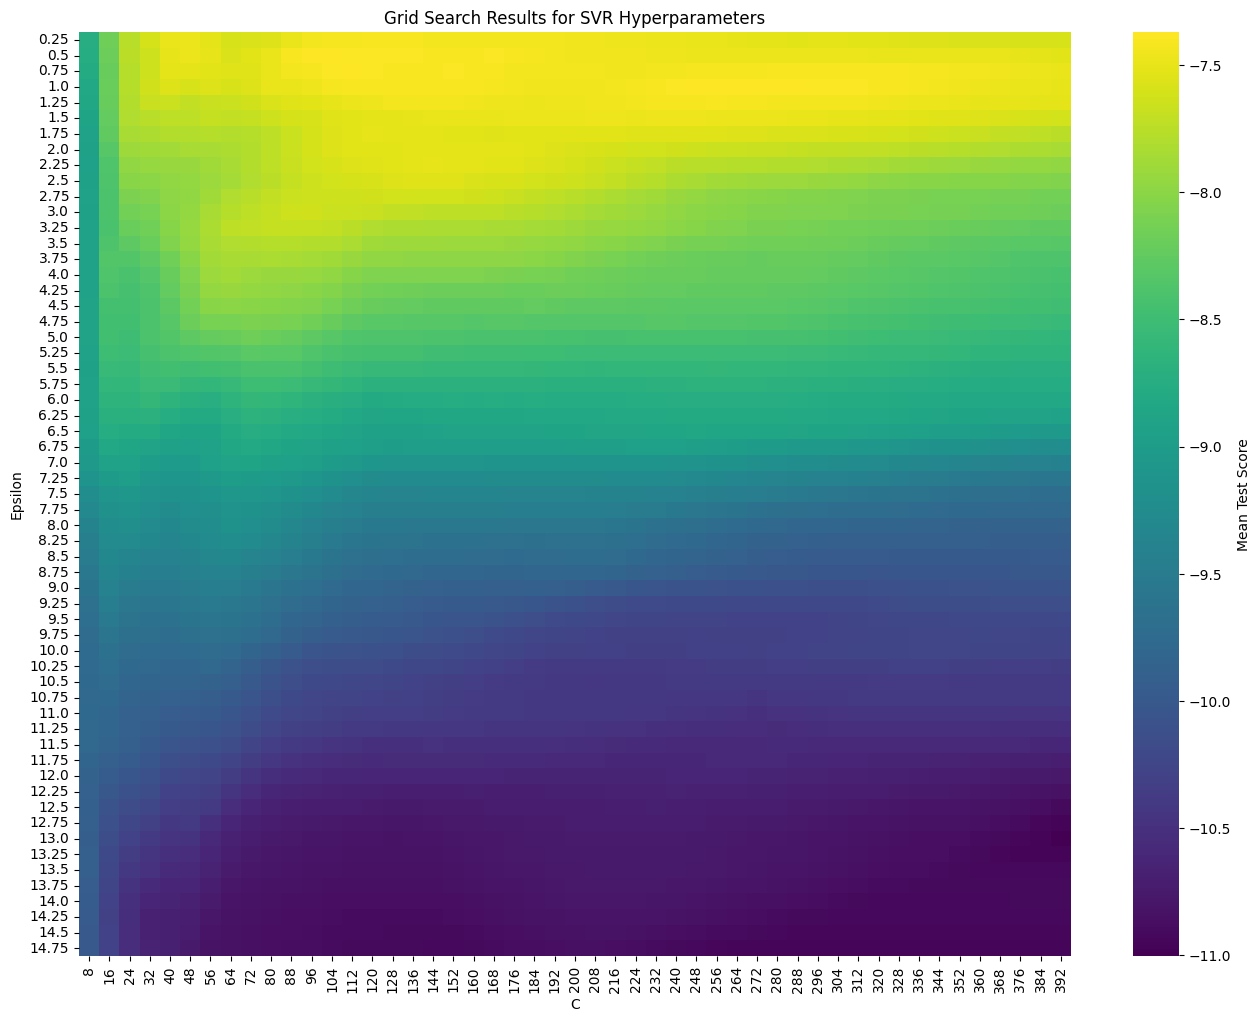

Best hyperparameters: {'C': 264, 'epsilon': 1.0}
With Score: -7.3699130665159105


['grid_search_diastole.pkl']

In [ ]:
def generate_combinations(arr):
  all_combinations = []
  for r in range(1, len(arr) + 1):
    # Menghasilkan semua kombinasi dengan panjang r
    combinations_r = list(combinations(arr, r))
    all_combinations.extend(combinations_r)
  return all_combinations

data = pd.read_csv('data-extraction-normalized.csv')

features = ["age", "weight", "bpm", "ibi", "sdnn", "sdsd", "rmssd", "pnn20", "pnn50", "hr_mad", "sd1", "sd2", "s", "sd1/sd2", "breathingrate"]
features_combination = generate_combinations(features)

X_y = []

for i in data.columns:
  X_y.append(list(data[i]))
  
X = np.array(X_y[2:])
y = np.array(X_y[1]) 

for i, X_combination in enumerate(generate_combinations(X)):
  # Split the dataset into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(np.array(list(X_combination)).transpose(), y, test_size=0.2, random_state=42)

  # Define the SVR model
  svr = SVR(kernel='rbf')

  # Define the parameter grid for hyperparameter tuning
  param_grid = {'C': np.arange(16, 400, 16), 'epsilon': np.arange(0.5, 15, 0.5)}

  # Create the GridSearchCV object
  grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_absolute_error')

  # Fit the model with the training data
  grid_search.fit(X_train, y_train)

  # best_model = grid_search.best_estimator_
  # joblib.dump(best_model, f"systole_model.pkl")

  # Get the results as a Pandas DataFrame
  results = pd.DataFrame(grid_search.cv_results_)

  # Reshape the results for heatmap
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')

  # Plot the heatmap
  plt.figure(figsize=(16, 12))
  sns.heatmap(heatmap_data, cmap='viridis', fmt=".4f", cbar_kws={'label': 'Mean Test Score'})
  plt.title(f"Best param: {grid_search.best_params_}, with score: {grid_search.best_score_}, X: {str(features_combination[i]).replace(' ', '')}")
  plt.xlabel('C')
  plt.ylabel('Epsilon')
  plt.show()

  # # Print the best hyperparameters
  # print("Best hyperparameters:", grid_search.best_params_)
  # print("With Score:", grid_search.best_score_)

  joblib.dump(grid_search, f"grid-search-result/diastole/{i}-{str(features_combination[i]).replace(' ', '')}.pkl")

# Correlation Matrix

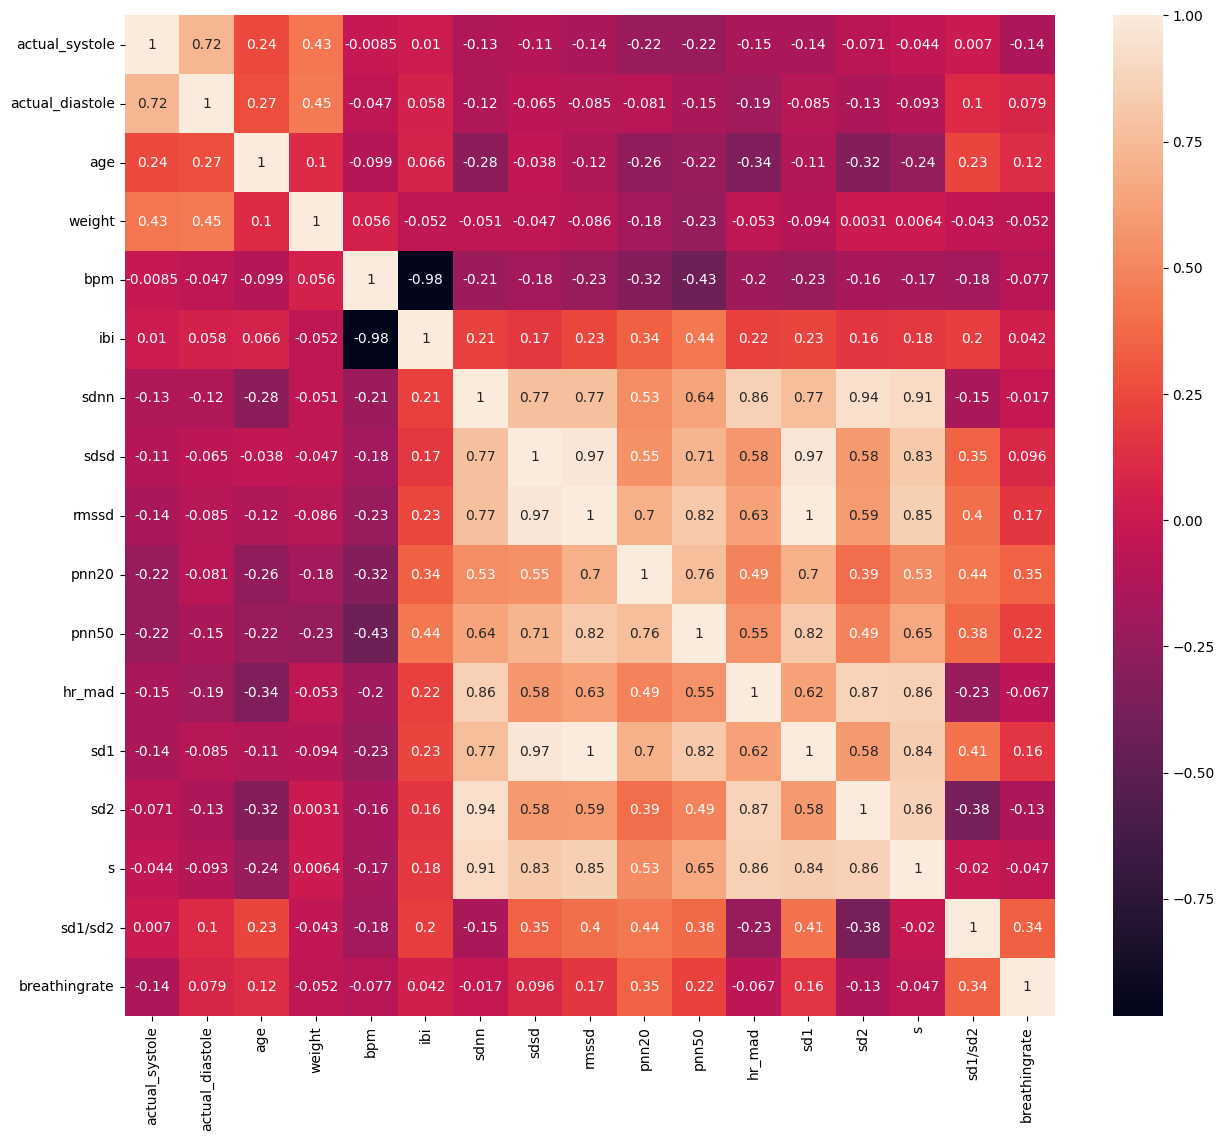

In [ ]:
data = pd.read_csv('data-extraction-normalized.csv')

corr_matrix = data.corr()
plt.figure(figsize=(15, 13))
sns.heatmap(corr_matrix, annot=True)
plt.show()


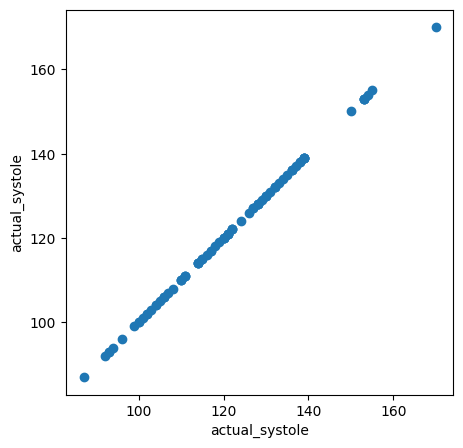

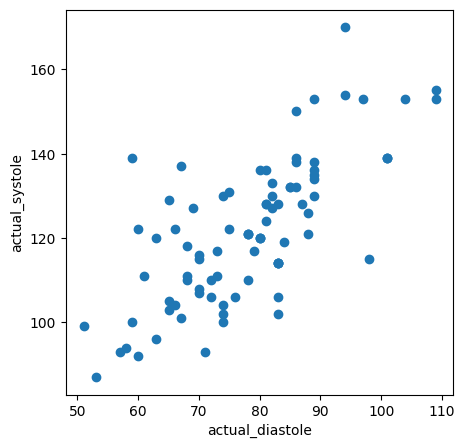

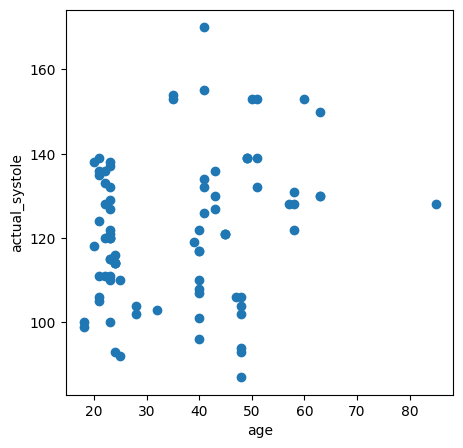

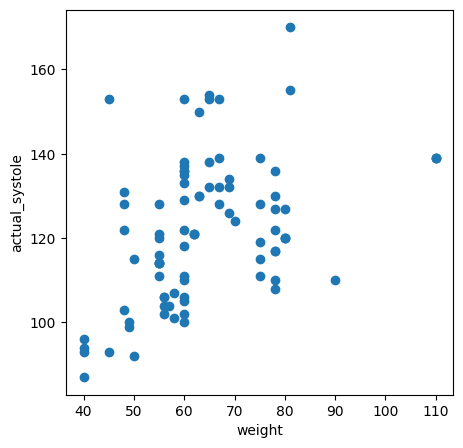

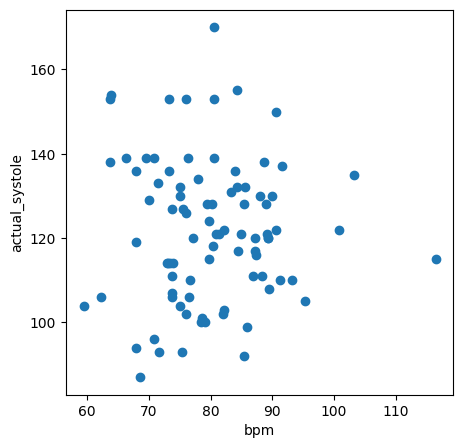

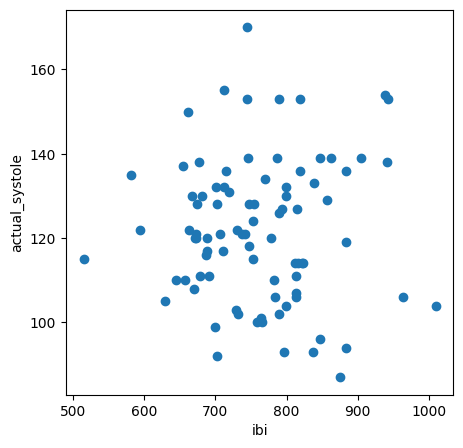

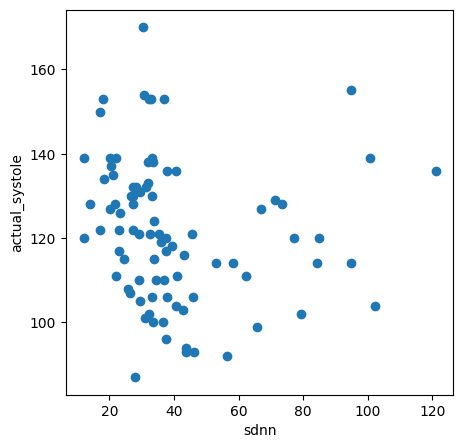

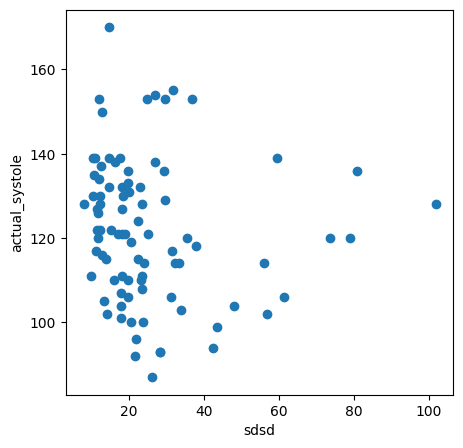

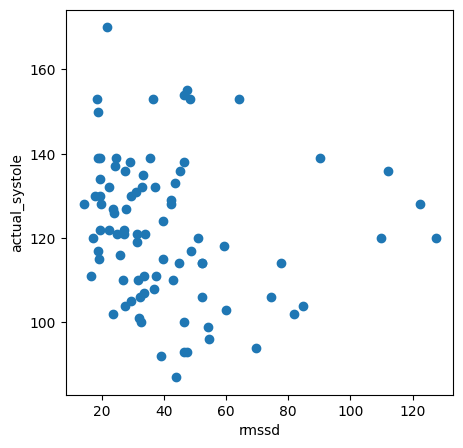

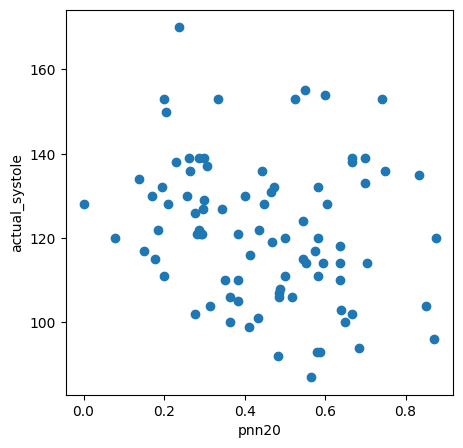

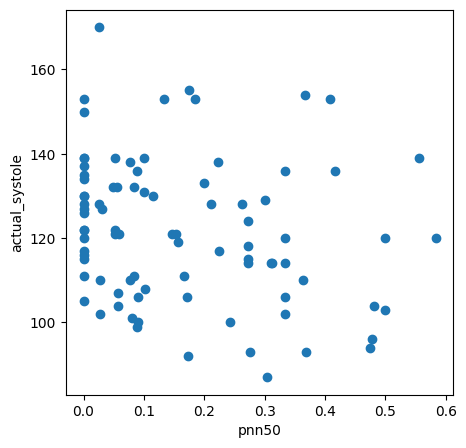

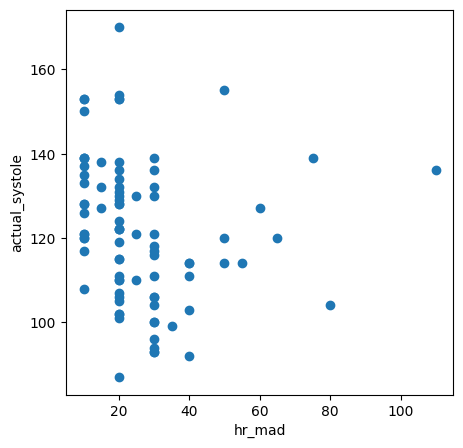

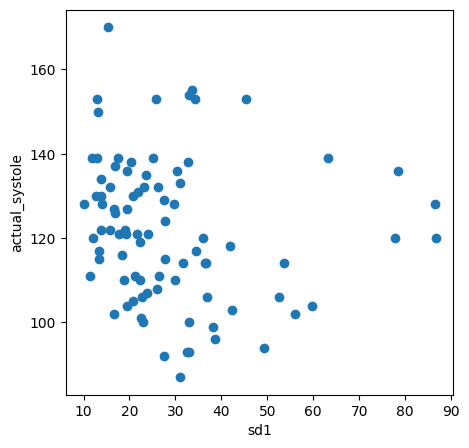

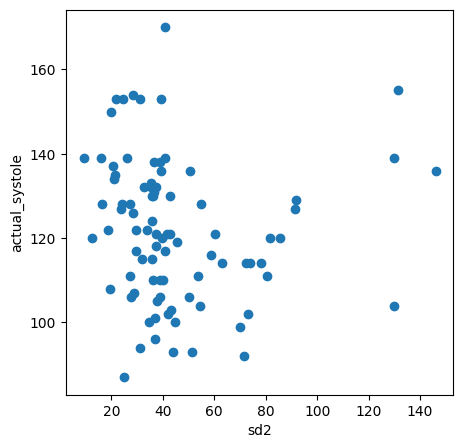

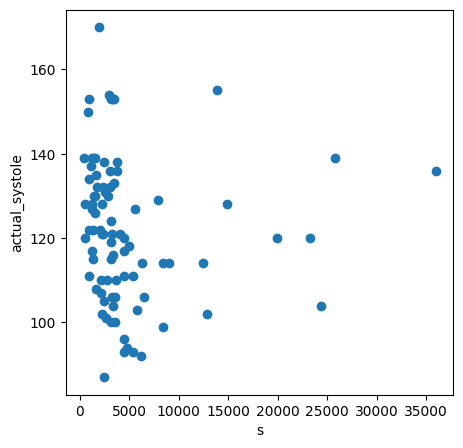

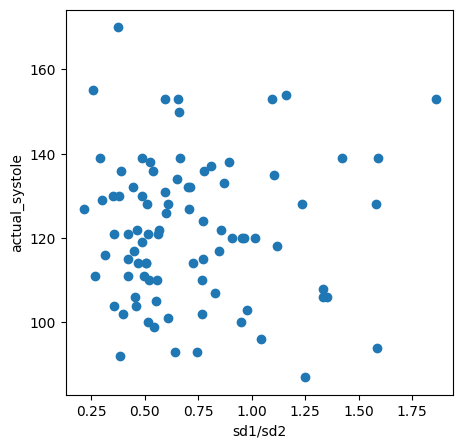

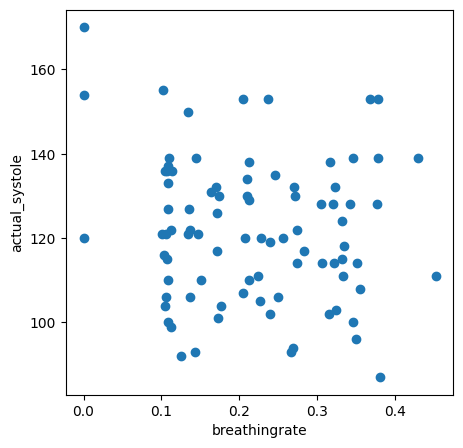

In [ ]:
data = pd.read_csv('data-extraction.csv')

for col in data.columns:
  plt.figure(figsize=(5,5))
  plt.scatter(data[col],data["actual_systole"])
  plt.xlabel(col)
  plt.ylabel("actual_systole")
  plt.show()

In [ ]:
from itertools import combinations

def generate_combinations(arr):
    all_combinations = []
    for r in range(1, len(arr) + 1):
        # Menghasilkan semua kombinasi dengan panjang r
        combinations_r = list(combinations(arr, r))
        all_combinations.extend(combinations_r)
    return all_combinations

arr = [1, 2, 3, 4, 5]
result = generate_combinations(arr)

# Menampilkan hasil
for combination in result:
    print(list(combination))


[1]
[2]
[3]
[4]
[5]
[1, 2]
[1, 3]
[1, 4]
[1, 5]
[2, 3]
[2, 4]
[2, 5]
[3, 4]
[3, 5]
[4, 5]
[1, 2, 3]
[1, 2, 4]
[1, 2, 5]
[1, 3, 4]
[1, 3, 5]
[1, 4, 5]
[2, 3, 4]
[2, 3, 5]
[2, 4, 5]
[3, 4, 5]
[1, 2, 3, 4]
[1, 2, 3, 5]
[1, 2, 4, 5]
[1, 3, 4, 5]
[2, 3, 4, 5]
[1, 2, 3, 4, 5]
